# 0. Импортируем необходимые библиотеки

In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 1. Загрузка и исследование данных

## 1.1. Загрузим необходимые для работы данные

In [32]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 1.2. Опишем, что означает каждый признак в датасете

> Целевая переменная:
* Transported - был ли пассажир перевезен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.
 

> Признаки:
* PassengerId - Уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg обозначает группу, с которой пассажир путешествует, а pp - его номер в группе. Люди в группе часто являются членами семьи, но не всегда.
* HomePlanet - планета, с которой пассажир улетел, обычно это планета его постоянного проживания.
* CryoSleep - указывает, решил ли пассажир погрузиться в анабиоз на время путешествия. Пассажиры, находящиеся в состоянии криосна, находятся в своих каютах.
* Cabin - Номер каюты, в которой находится пассажир. Имеет форму deck/num/side, где сторона может быть либо P для левого борта, либо S для правого.
* Destination - планета, на которую пассажир будет высаживаться.
* Age - возраст пассажира.
* VIP - Оплачивал ли пассажир специальные VIP-услуги во время рейса.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - сумма, которую пассажир заплатил за каждый из многочисленных роскошных удобств космического корабля "Титаник".
* Name - имя и фамилия пассажира.


## 1.3. Изучим данные

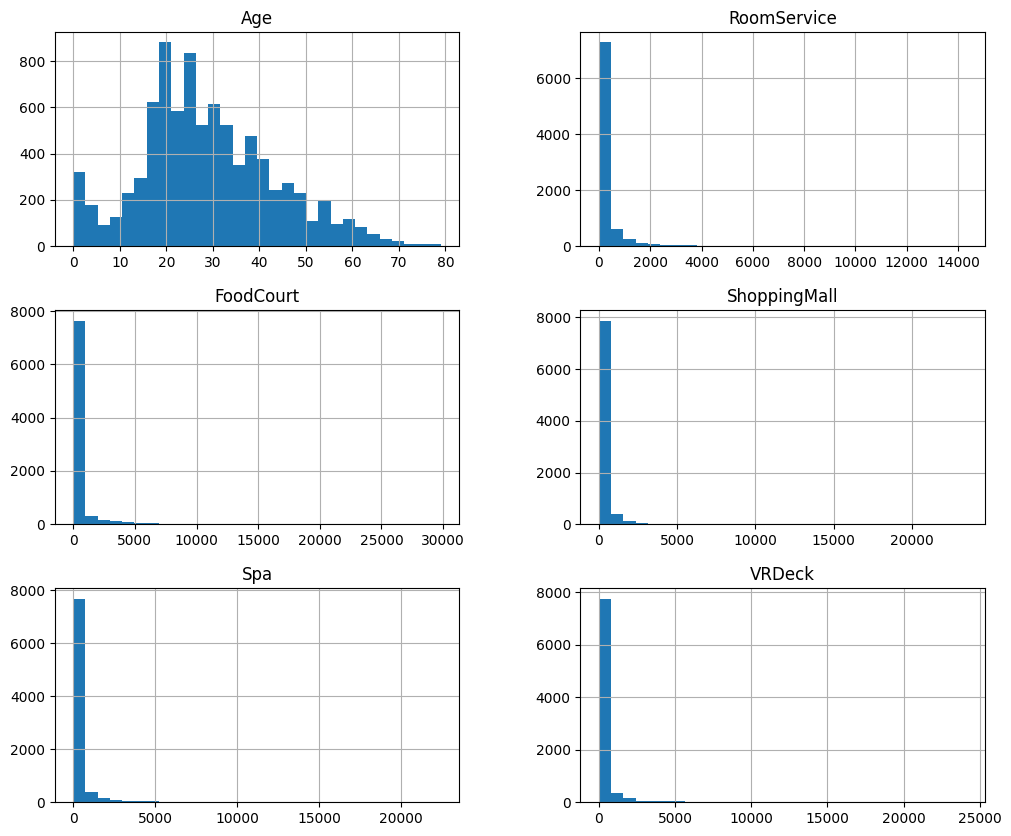

In [33]:
train.hist(figsize=(12, 10), bins=30)
plt.show()

In [34]:
# Подсчёт значений целевой переменной Transported
class_counts = train['Transported'].value_counts()

# Вывод результатов
print(f"Количество 1 (пассажиров, которые были перенесены в другое измерение): {class_counts[1]}")
print(f"Количество 0 (пассажиров, которые не были перенесены в другое измерение): {class_counts[0]}")

Количество 1 (пассажиров, которые были перенесены в другое измерение): 4315
Количество 0 (пассажиров, которые не были перенесены в другое измерение): 4378


/tmp/ipykernel_33/4039872110.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Количество 1 (пассажиров, которые были перенесены в другое измерение): {class_counts[1]}")
/tmp/ipykernel_33/4039872110.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Количество 0 (пассажиров, которые не были перенесены в другое измерение): {class_counts[0]}")


Изучив данные, замечаем, что дисбаланса классов нет, так что принимать меры по его решению не придётся.

## 2. Обработка данных

## 2.1. Посмотрим количество пропущенных значений для каждого признака

In [35]:
print("Пропущенные значения в train.csv:")
print(train.isnull().sum())
print("\nПропущенные значения в test.csv:")
print(test.isnull().sum())

Пропущенные значения в train.csv:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Пропущенные значения в test.csv:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### 2.2 Посмотрим количества пропущенных значений для каждой фичи (т.е. для каждого столбца) в процентах

In [36]:
print("Пропущенные значения в train.csv в %:")
print((train.isnull().sum() / train.shape[0] * 100).round(2).astype(str) + "%")
print("\nПропущенные значения в test.csv в %:")
print((test.isnull().sum() / test.shape[0] * 100).round(2).astype(str) + "%")

Пропущенные значения в train.csv в %:
PassengerId      0.0%
HomePlanet      2.31%
CryoSleep        2.5%
Cabin           2.29%
Destination     2.09%
Age             2.06%
VIP             2.34%
RoomService     2.08%
FoodCourt       2.11%
ShoppingMall    2.39%
Spa             2.11%
VRDeck          2.16%
Name             2.3%
Transported      0.0%
dtype: object

Пропущенные значения в test.csv в %:
PassengerId      0.0%
HomePlanet      2.03%
CryoSleep       2.17%
Cabin           2.34%
Destination     2.15%
Age             2.13%
VIP             2.17%
RoomService     1.92%
FoodCourt       2.48%
ShoppingMall    2.29%
Spa             2.36%
VRDeck          1.87%
Name             2.2%
dtype: object


Заметим, что пропуски есть во многих столбцах, однако доли пропущенных значений небольшие. Поэтому мы сохраним все признаки, а пропущенные значения просто заменим на их медианы (или моды для категориальных признаков).

## 2.3 Заменим пропущенные значения на медианы (или моды)

In [37]:
# заменяем пропущенные значения для столбца HomePlanet
train['HomePlanet'] = train['HomePlanet'].fillna(train['HomePlanet'].mode()[0])
test['HomePlanet'] = test['HomePlanet'].fillna(test['HomePlanet'].mode()[0])

# заменяем пропущенные значения для столбца CryoSleep
train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mode()[0])
test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mode()[0])

# для Cabin не заменяем, т.к. фича не будет использоваться для обучения модели

# заменяем пропущенные значения для столбца Destination
train['Destination'] = train['Destination'].fillna(train['Destination'].mode()[0])
test['Destination'] = test['Destination'].fillna(test['Destination'].mode()[0])

# заменяем пропущенные значения для столбца Age
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

# заменяем пропущенные значения для столбца VIP
train['VIP'] = train['VIP'].fillna(train['VIP'].mode()[0])
test['VIP'] = test['VIP'].fillna(test['VIP'].mode()[0])

# заменяем пропущенные значения для столбца RoomService
train['RoomService'] = train['RoomService'].fillna(train['RoomService'].median())
test['RoomService'] = test['RoomService'].fillna(test['RoomService'].median())

# заменяем пропущенные значения для столбца FoodCourt
train['FoodCourt'] = train['FoodCourt'].fillna(train['FoodCourt'].median())
test['FoodCourt'] = test['FoodCourt'].fillna(test['FoodCourt'].median())

# заменяем пропущенные значения для столбца ShoppingMall
train['ShoppingMall'] = train['ShoppingMall'].fillna(train['ShoppingMall'].median())
test['ShoppingMall'] = test['ShoppingMall'].fillna(test['ShoppingMall'].median())

# заменяем пропущенные значения для столбца Spa
train['Spa'] = train['Spa'].fillna(train['Spa'].median())
test['Spa'] = test['Spa'].fillna(test['Spa'].median())

# заменяем пропущенные значения для столбца VRDeck
train['VRDeck'] = train['VRDeck'].fillna(train['VRDeck'].median())
test['VRDeck'] = test['VRDeck'].fillna(test['VRDeck'].median())

# для Name не заменяем, т.к. фича не будет использоваться для обучения модел

/tmp/ipykernel_33/3948600977.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['CryoSleep'] = train['CryoSleep'].fillna(train['CryoSleep'].mode()[0])
/tmp/ipykernel_33/3948600977.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['CryoSleep'] = test['CryoSleep'].fillna(test['CryoSleep'].mode()[0])
/tmp/ipykernel_33/3948600977.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `

## 2.4 Убедимся, что пропущенных значений больше не осталось

In [38]:
print("Пропущенные значения в train.csv:")
print(train.isnull().sum())
print("\nПропущенные значения в test.csv:")
print(test.isnull().sum())

Пропущенные значения в train.csv:
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

Пропущенные значения в test.csv:
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name             94
dtype: int64


## 2.5. Работа с выбросами в данных

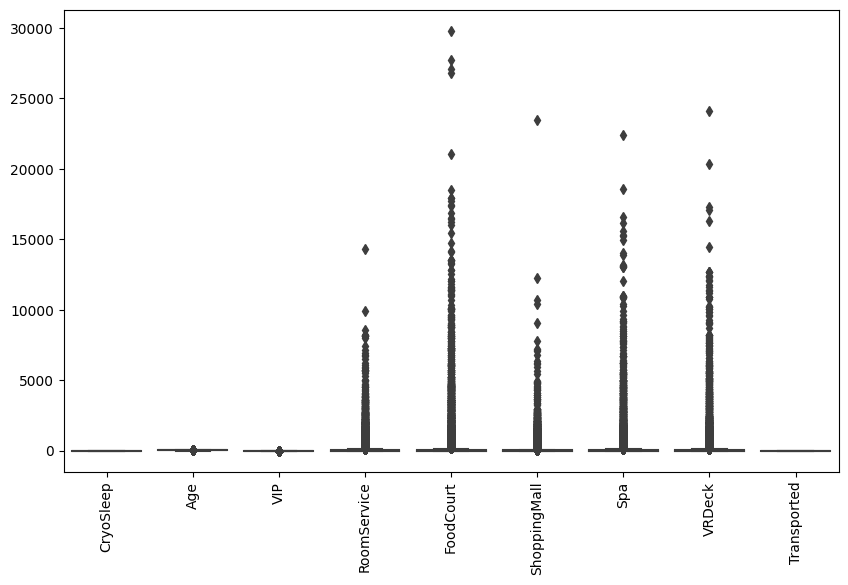

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

С помощью boxplot мы убедились, что в данных есть множество объектов с сильно отличающимися от других объектов значениями признаков. Однако эти данные необходимо оставить, ведь помогают модели ознакомиться с редкими, но возможными сценариями. 

## 2.6. Добавим новые признаки

Добавим признак Side, который будет равен 0, если кабина у левого борта и 1, если кабина у правого борта.

In [40]:
train['Side'] = train['Cabin'].apply(lambda x: 1 if isinstance(x, str) and x[-1] == 'S' else 0)
test['Side'] = test['Cabin'].apply(lambda x: 1 if isinstance(x, str) and x[-1] == 'S' else 0)

# просмотр первых строк с новым признаком
train[['Cabin', 'Side']].head()

,Cabin,Side
0,B/0/P,0
1,F/0/S,1
2,A/0/S,1
3,A/0/S,1
4,F/1/S,1


# 3. Закодируем категориальные признаки

## 3.1. Узнаем количества значений, принимаемых категориальными признаками

In [41]:
categories = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for category in categories:
    print(f"Num of unique values for {category}: {train[category].nunique()}")

Num of unique values for HomePlanet: 3
Num of unique values for CryoSleep: 2
Num of unique values for Destination: 3
Num of unique values for VIP: 2


## 3.2. Получили для HomePlanet и Destination по 3 различных уникальных значения, а для CryoSleep и VIP по 2 (то есть они бинарные). Тогда для кодирования HomePlanet и Destination будем использовать One-Hot Encoding, а для кодирования CryoSleep и VIP - Label Encoding

In [42]:
# One-Hot Encoding для HomePlanet и Destination
train = pd.get_dummies(train, columns=['HomePlanet', 'Destination'], dtype=int)
test = pd.get_dummies(test, columns=['HomePlanet', 'Destination'], dtype=int)

# Label Encoding для CryoSleep
train['CryoSleep'] = train['CryoSleep'].map({True: 1, False: 0})
test['CryoSleep'] = test['CryoSleep'].map({True: 1, False: 0})

# Label Encoding для VIP
train['VIP'] = train['VIP'].map({True: 1, False: 0})
test['VIP'] = test['VIP'].map({True: 1, False: 0})

In [43]:
train.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Side,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,B/0/P,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,0,1,0,0,0,1
1,0002_01,0,F/0/S,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1,0,0,0,0,1
2,0003_01,0,A/0/S,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0,1,0,0,0,1
3,0003_02,0,A/0/S,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0,1,0,0,0,1
4,0004_01,0,F/1/S,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1,0,0,0,0,1


Сделаем корреляционную матрицу, чтобы посмотреть корреляции между различными признаками.

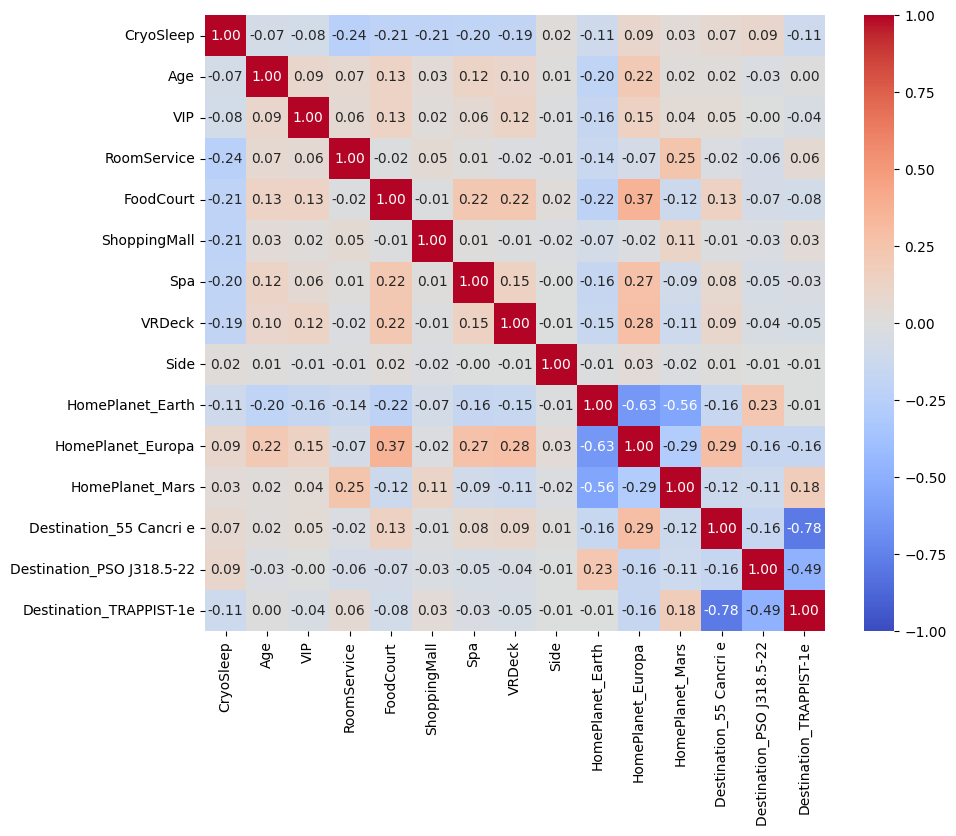

In [44]:
# выбор признаков
selected_features = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
                    'VRDeck', 'Side', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
                    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']

# расчет корреляционной матрицы только для выбранных признаков
corr_matrix = train[selected_features].corr()

# построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.show()


# 4. Нормализация числовых данных

Так как мы будем использовать модель машинного обучения XGBoost, которая основана на решающих деревьях, то нормализация данных не требуется.

In [45]:
# так могла бы выглядеть нормализация:
# scaler = StandardScaler()
# features_to_normalize = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# train[features_to_normalize] = scaler.fit_transform(train[features_to_normalize])
# test[features_to_normalize] = scaler.transform(test[features_to_normalize])

# train.head()

# 5. Выберем и обучим модель машинного обучения

Для данной задачи возьмём модель машинного обучения XGBoost (Extreme Gradient Boosting), так как она обладает высокой предсказательной мощностью и эффективно обрабатывает большие данные (однако подошёл бы и CatBoost и он даже не требовал бы кодирования категориальных признаков в этой задаче).

In [46]:
features = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
                    'VRDeck', 'Side', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
                    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e']

X = train[features]
y = train['Transported']

# Разделение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели XGBoost
model = xgb.XGBClassifier(eval_metric='logloss')  # Указываем eval_metric для корректной работы XGBoost
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')

Accuracy: 0.7843588269120184


# 6. Воспользуемся моделью для предсказания на тестовом наборе


In [47]:
# Предсказание на тестовом наборе
X_test = test[features]
predictions = model.predict(X_test)

# Преобразование числовых предсказаний в булевы значения
predictions = [True if x == 1 else False for x in predictions]

# Сохранение результатов в файл
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': predictions})
submission.to_csv('submission.csv', index=False)